### Import packages

In [1]:
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from bayes_opt import BayesianOptimization

from utilities import cal_score, convert_types

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP li

### Columns

In [2]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250', 'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000', 'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000', 'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000', 'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN', 'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10', 'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10', 'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN', 'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000', 'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000', 'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500', 'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500', 'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50', 'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000', 'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500', 'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500', 'XIV_index_1000']
cols_feats = cols_num + cols_cat + cols_bin

col_target = 'total_price'
col_target_log1p = 'target'

### Read data

In [3]:
df = pd.read_csv('dataset/train.csv', dtype=object)

In [4]:
df.columns

Index(['building_id', 'building_material', 'city', 'txn_dt', 'total_floor',
       'building_type', 'building_use', 'building_complete_dt', 'parking_way',
       'parking_area',
       ...
       'XIV_500', 'XIV_index_500', 'XIV_1000', 'XIV_index_1000', 'XIV_5000',
       'XIV_index_5000', 'XIV_10000', 'XIV_index_10000', 'XIV_MIN',
       'total_price'],
      dtype='object', length=235)

### Preprocessing

In [5]:
# Convert types
df = convert_types(df, cols_num, col_target=col_target)

# Generate feats (train-test-same feats)
#create_feats(df)

### Target transform

In [6]:
def target_transform(df):  # Add new columns inplace!!
    '''Transform the original target to the target for model to train on'''
    df['log_total_price'] = np.log1p(df['total_price'])
    return df

def target_inverse_transform(df, y_pred):
    '''Inverse transorform the model target to the original target of our problem'''
    y_pred_expm1 = np.expm1(y_pred)
    y_pred_final = np.clip(y_pred_expm1, 0, None)
    return y_pred_final            

In [7]:
df = target_transform(df)

In [8]:
# transformed target fit by the model
col_model_target = 'log_total_price'
#col_model_target = 'total_price'

### Feat engineering

In [9]:
from feature_engineering import CategoricalColumnsEncoder

In [10]:
class FeatureEngineering():
    def __init__(self):
        pass
    
    def fit_transform(self, df, cols_cat, cols_bin):
        df = df.copy()
        # Denote categorical-type
        self.cat_encoder = CategoricalColumnsEncoder(mode='pandas')
        self.cat_encoder.fit_transform(df, cols_cat+cols_bin)
        return df
    
    def transform(self, df):
        df = df.copy()
        self.cat_encoder.transform(df)
        return df

### Grid search

#### Prepare kfolds

In [11]:
n_folds = 3
feat_engs = []
df_trains = []
df_vals = []
folds = KFold(n_splits=n_folds, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]

    # feat eng
    feat_eng = FeatureEngineering()
    df_train = feat_eng.fit_transform(df_train, cols_cat, cols_bin)
    df_val = feat_eng.transform(df_val)
    
    feat_engs.append(feat_eng)
    df_trains.append(df_train)
    df_vals.append(df_val)

#### Bayesian Optimization

In [12]:
# grid search
params_fix = {'task': 'train',
              'boosting_type': 'gbdt',
              'objective': 'mse',
              'metric': 'mse',
              }
lgb_other_params = {'num_boost_round': 15000,
                    'verbose_eval': 2000,
                    'early_stopping_rounds': 1000,
                   }

In [13]:
int_params = ['num_leaves', 'min_data_in_leaf']  # list of params that needs to be int
def fix_params(params):
    """Fix the params into int"""
    for c in int_params:
        if c in params: 
            params[c] = int(round(params[c]))
    return params

In [14]:
def kfold_cv(**params_update):
    params_update = fix_params(params_update)
    params = params_fix.copy()
    params.update(params_update)
    
    print('params:', params)

    scores = []
    scores2 = []
    for i_fold, (df_train, df_val) in enumerate(zip(df_trains, df_vals)):
        print('==== Fold', i_fold+1, '====')

        # Construct lgb dataset
        lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_model_target]).construct()
        lgb_val = lgb.Dataset(df_val[cols_feats], df_val[col_model_target], reference=lgb_train).construct()

        model = lgb.train(params, lgb_train, valid_sets=lgb_val, **lgb_other_params)

        y_pred = model.predict(df_val[cols_feats])

        y_pred_final = target_inverse_transform(df_val, y_pred)

        score = mean_squared_log_error(df_val['total_price'], y_pred_final)
        score2 = cal_score(df_val['total_price'], y_pred_final)
        
        scores.append(score)
        scores2.append(score2)
    
    tuple_params = tuple(params.items())
    result = [tuple_params, np.mean(scores), scores, np.mean(scores2), scores2]
    gsearch_results.append(result)
    return result[1]

In [15]:
gsearch_results = []

In [16]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {
    'learning_rate': (0.005, 0.05),
    'num_leaves': (63, 511),           # may reduce in dim-reduction exp
    'feature_fraction': (0.1, 1.0),
    'min_data_in_leaf': (5, 100),
    'lambda_l1': (0., 10.),
    'lambda_l2': (0., 10.),
}

optimizer = BayesianOptimization(
    f=kfold_cv,
    pbounds=pbounds,
    random_state=1,
)

In [17]:
%%time
optimizer.maximize(
    init_points=10,
    n_iter=65,
)

|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | min_da... | num_le... |
-------------------------------------------------------------------------------------------------
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mse', 'feature_fraction': 0.47531980423231657, 'lambda_l1': 7.203244934421581, 'lambda_l2': 0.0011437481734488664, 'learning_rate': 0.01860496576843279, 'min_data_in_leaf': 19, 'num_leaves': 104}
==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's l2: 0.0437065
Early stopping, best iteration is:
[2782]	valid_0's l2: 0.0430133
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's l2: 0.0451212
Early stopping, best iteration is:
[2639]	valid_0's l2: 0.0445193
==== Fold 3 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's l2: 0.0454295
Early stopping, best iteration is:
[2642]	valid_0's l2: 0.

==== Fold 3 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's l2: 0.0458979
Early stopping, best iteration is:
[2627]	valid_0's l2: 0.0456155
|  8        |  0.04498  |  0.3524   |  7.893    |  1.032    |  0.02516  |  91.32    |  194.5    |
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mse', 'feature_fraction': 0.3589978047277139, 'lambda_l1': 1.3002857211827767, 'lambda_l2': 0.19366957870297075, 'learning_rate': 0.0355475989822951, 'min_data_in_leaf': 25, 'num_leaves': 182}
==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's l2: 0.0408939
[4000]	valid_0's l2: 0.0408013
Early stopping, best iteration is:
[3129]	valid_0's l2: 0.0408013
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's l2: 0.0426799
[4000]	valid_0's l2: 0.0425796
Early stopping, best iteration is:
[3167]	valid_0's l2: 0.0425796
==== Fold 3 ====
Training until

Early stopping, best iteration is:
[937]	valid_0's l2: 0.0464029
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[963]	valid_0's l2: 0.0470226
==== Fold 3 ====
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[911]	valid_0's l2: 0.047488
|  16       |  0.04685  |  0.6781   |  8.668    |  0.6549   |  0.04815  |  99.91    |  509.7    |
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mse', 'feature_fraction': 0.7840584170394573, 'lambda_l1': 8.693380672195396, 'lambda_l2': 2.1772883919410493, 'learning_rate': 0.030982186629406643, 'min_data_in_leaf': 6, 'num_leaves': 510}
==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's l2: 0.0471741
Early stopping, best iteration is:
[1044]	valid_0's l2: 0.0471741
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
Early stoppin

[6000]	valid_0's l2: 0.0498828
[8000]	valid_0's l2: 0.0498416
Early stopping, best iteration is:
[7448]	valid_0's l2: 0.0498416
|  24       |  0.04851  |  0.1644   |  9.91     |  8.805    |  0.02417  |  7.035    |  502.0    |
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mse', 'feature_fraction': 0.10970255890366776, 'lambda_l1': 9.90534750634953, 'lambda_l2': 9.874552211375384, 'learning_rate': 0.04168424929754474, 'min_data_in_leaf': 21, 'num_leaves': 510}
==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's l2: 0.050813
[4000]	valid_0's l2: 0.0494322
[6000]	valid_0's l2: 0.0491192
[8000]	valid_0's l2: 0.0489625
Early stopping, best iteration is:
[8831]	valid_0's l2: 0.048917
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's l2: 0.051595
[4000]	valid_0's l2: 0.0502124
[6000]	valid_0's l2: 0.0499208
[8000]	valid_0's l2: 0.0497954
Early stopping, best iterati

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's l2: 0.0456013
[4000]	valid_0's l2: 0.0449796
Early stopping, best iteration is:
[3736]	valid_0's l2: 0.0449796
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's l2: 0.0470608
[4000]	valid_0's l2: 0.0465773
Early stopping, best iteration is:
[3318]	valid_0's l2: 0.0465773
==== Fold 3 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's l2: 0.0474106
[4000]	valid_0's l2: 0.0468419
Early stopping, best iteration is:
[3670]	valid_0's l2: 0.0468419
|  32       |  0.04604  |  0.3685   |  9.987    |  9.51     |  0.01783  |  13.59    |  505.0    |
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mse', 'feature_fraction': 0.47570995300907626, 'lambda_l1': 9.918614937176551, 'lambda_l2': 9.675699818228212, 'learning_rate': 0.046296646407412254, 'min_data_in_leaf': 9, 'num_leaves': 510}
==== Fold 1 ====
T

[2000]	valid_0's l2: 0.0478108
Early stopping, best iteration is:
[1078]	valid_0's l2: 0.0478107
|  40       |  0.04719  |  0.5015   |  9.835    |  9.693    |  0.04099  |  13.36    |  503.9    |
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mse', 'feature_fraction': 0.7675301816521466, 'lambda_l1': 9.99063815180691, 'lambda_l2': 8.251414603758748, 'learning_rate': 0.04775162621011524, 'min_data_in_leaf': 7, 'num_leaves': 510}
==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[691]	valid_0's l2: 0.0477723
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[638]	valid_0's l2: 0.0487552
==== Fold 3 ====
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[664]	valid_0's l2: 0.0493709
|  41       |  0.04853  |  0.7675   |  9.991    |  8.251    |  0.04775  |  6.704    |  509.7    

Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[712]	valid_0's l2: 0.0477376
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[707]	valid_0's l2: 0.0491351
==== Fold 3 ====
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[723]	valid_0's l2: 0.049297
|  49       |  0.04862  |  0.7955   |  9.949    |  0.1844   |  0.04256  |  5.254    |  502.9    |
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mse', 'feature_fraction': 0.23044218765138896, 'lambda_l1': 9.935965242408468, 'lambda_l2': 9.04128531221711, 'learning_rate': 0.03241375418144026, 'min_data_in_leaf': 6, 'num_leaves': 511}
==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's l2: 0.0471998
[4000]	valid_0's l2: 0.0469109
Early stopping, best iteration is:
[3768]	valid_0's l2: 0.0469109
=

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's l2: 0.0463759
Early stopping, best iteration is:
[1482]	valid_0's l2: 0.0463759
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's l2: 0.0485405
Early stopping, best iteration is:
[1291]	valid_0's l2: 0.0485405
==== Fold 3 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's l2: 0.0485761
Early stopping, best iteration is:
[1375]	valid_0's l2: 0.0485761
|  58       |  0.04775  |  0.4816   |  9.828    |  9.211    |  0.03529  |  5.281    |  504.4    |
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mse', 'feature_fraction': 0.2797936416330417, 'lambda_l1': 9.90290929331267, 'lambda_l2': 9.733844202240684, 'learning_rate': 0.04546881260898467, 'min_data_in_leaf': 7, 'num_leaves': 503}
==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's l2: 0.0468527
Ea

params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mse', 'feature_fraction': 0.2884896175420941, 'lambda_l1': 9.902648297144545, 'lambda_l2': 1.016633013430216, 'learning_rate': 0.016372152106350502, 'min_data_in_leaf': 7, 'num_leaves': 510}
==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's l2: 0.0469648
[4000]	valid_0's l2: 0.0457538
[6000]	valid_0's l2: 0.04571
Early stopping, best iteration is:
[6231]	valid_0's l2: 0.0457092
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's l2: 0.0483163
[4000]	valid_0's l2: 0.0471881
[6000]	valid_0's l2: 0.0471288
Early stopping, best iteration is:
[5858]	valid_0's l2: 0.0471288
==== Fold 3 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's l2: 0.0488512
[4000]	valid_0's l2: 0.0477868
[6000]	valid_0's l2: 0.0477197
Early stopping, best iteration is:
[6194]	valid_0's l2: 0.0477145
|  67    

==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[729]	valid_0's l2: 0.0503505
==== Fold 3 ====
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[765]	valid_0's l2: 0.0507779
|  74       |  0.05031  |  0.9829   |  9.959    |  4.617    |  0.03993  |  6.719    |  511.0    |
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mse', 'feature_fraction': 0.8768772948717917, 'lambda_l1': 9.98783508560541, 'lambda_l2': 9.9816627420466, 'learning_rate': 0.00500719048605584, 'min_data_in_leaf': 13, 'num_leaves': 503}
==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's l2: 0.0521642
[4000]	valid_0's l2: 0.0486272
[6000]	valid_0's l2: 0.0476383
Early stopping, best iteration is:
[6390]	valid_0's l2: 0.0475409
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's l2

In [18]:
optimizer.max

{'target': 0.05047890218617407,
 'params': {'feature_fraction': 0.9977985155703246,
  'lambda_l1': 9.91176022187653,
  'lambda_l2': 8.657567280519165,
  'learning_rate': 0.03267154970200335,
  'min_data_in_leaf': 6.31186519863041,
  'num_leaves': 509.7232959856985}}

In [20]:
gsearch_results.sort(key= lambda x: x[3], reverse=True)

In [21]:
gsearch_results

[[(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mse'),
   ('feature_fraction', 0.5424158433523045),
   ('lambda_l1', 0.5336254511708038),
   ('lambda_l2', 5.741176054920131),
   ('learning_rate', 0.011602785870761457),
   ('min_data_in_leaf', 61),
   ('num_leaves', 376)),
  0.04182564098642947,
  [0.04050323531717287, 0.04216274712135366, 0.042810940520761905],
  5429.861085801814,
  [5451.862709137021, 5392.8626164102825, 5444.857931858137]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mse'),
   ('feature_fraction', 0.3589978047277139),
   ('lambda_l1', 1.3002857211827767),
   ('lambda_l2', 0.19366957870297075),
   ('learning_rate', 0.0355475989822951),
   ('min_data_in_leaf', 25),
   ('num_leaves', 182)),
  0.04200684813503281,
  [0.040745561824639676, 0.042421172493554864, 0.042853810086903886],
  5387.526359480058,
  [5411.861139047588, 5345.860964561245, 5404.85697483134]],
 [(('task', 'tra

### Plots

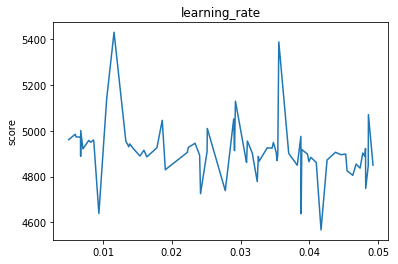

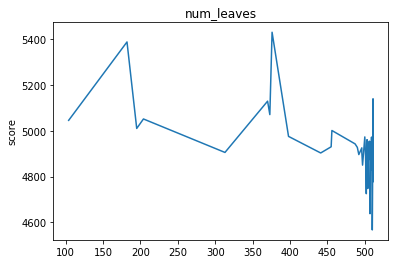

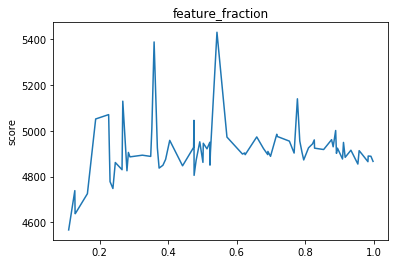

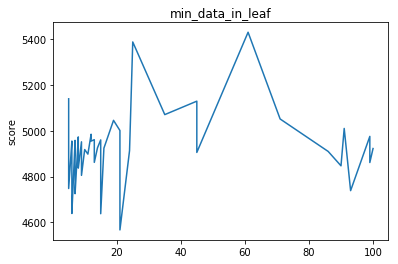

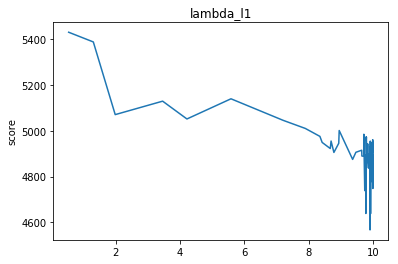

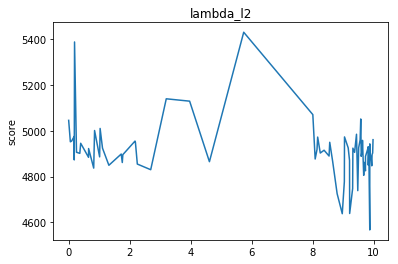

In [28]:
for param_name in pbounds:
    x_y = [[dict(row[0])[param_name], row[3]] for row in gsearch_results]
    x_y.sort(key=lambda xy: xy[0])
    x_y = np.array(x_y)
    plt.plot(x_y[:, 0], x_y[:, 1])
    plt.title(param_name); plt.ylabel('score')
    plt.show()

### Conclusion

Do not use mse to early stop. Fluctuation can kill it.

### Other info

In [29]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5)
plt.show()

NameError: name 'model' is not defined

In [30]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5, importance_type='gain')
plt.show()

NameError: name 'model' is not defined